<h1><span style="color: #6495ED;">Delhi Air Quality Prediction</span></h1>

<h2><span style="color: #6495ED;">Exploratory Data Analysis (EDA)</span></h2>

Prepared by Lipsita Tripathy

December 2023

## Introduction

Welcome to the Exploratory Data Analysis (EDA) phase of our project, where we dive deep into the intricacies of our dataset to uncover valuable insights. EDA is a crucial step that sets the stage for informed decision-making in subsequent modeling. In this notebook, we'll unravel the patterns, trends, and relationships within our data, shedding light on key factors that influence air quality in Delhi. Let's discover a comprehensive understanding of the features and dynamics that shape our dataset.

## Data Dictionary

For this project, we're using air quality data gathered from 40 stations across Delhi, covering the period from 2013 to 2023. The dataset includes 12 distinct features, each representing different air quality and environmental parameters. These data points are collected from each station and then aggregated to form a comprehensive dataset with unique datetime records for each entry.

| Features                  | Description                                                | Type       |
|---------------------------|------------------------------------------------------------|------------|
| Datetime                  | Timestamp indicating the date and time of the recorded data | datetime64 |
| StationId                 | Unique identifier for each monitoring station              | Numeric    |
| PM2.5 (ug/m3)             | Particulate Matter with a diameter of 2.5 microns or less   | Numeric    |
| PM10 (ug/m3)              | Particulate Matter with a diameter of 10 microns or less   | Numeric    |
| NO (ug/m3)                | Nitric Oxide concentration                                 | Numeric    |
| NO2 (ug/m3)               | Nitrogen Dioxide concentration                              | Numeric    |
| NOx (ug/m3)               | Sum of Nitric Oxide and Nitrogen Dioxide concentrations    | Numeric    |
| NH3 (ug/m3)               | Ammonia concentration                                      | Numeric    |
| SO2 (ug/m3)               | Sulfur Dioxide concentration                               | Numeric    |
| CO (ug/m3)                | Carbon Monoxide concentration                              | Numeric    |
| Ozone (ug/m3)             | Ozone concentration                                        | Numeric    |
| Benzene (ug/m3)           | Concentration of Benzene in the air                         | Numeric    |
| Toluene (ug/m3)           | Concentration of Toluene in the air                         | Numeric    |
| Xylene (ug/m3)            | Concentration of Xylene in the air                          | Numeric    |
| RH (%)                    | Relative Humidity in percentage                            | Numeric    |
| WS (m/s)                  | Wind Speed in meters per second                             | Numeric    |
| WD (degree)               | Wind Direction in degrees                                  | Numeric    |
| BP (mmHg)                 | Barometric Pressure in millimeters of mercury              | Numeric    |
| AT (degree C)             | Ambient Temperature in degrees Celsius                     | Numeric    |
| RF (mm)                   | Rainfall in millimeters                                    | Numeric    |
| SR (W/mt2)                | Solar Radiation in Watts per square meter                   | Numeric    |


| Target                    | Description                                                | Type       |
|---------------------------|------------------------------------------------------------|------------|
| <span style="color: #FF0000;">y_AQI</span> | Target variable representing the predicted Air Quality Index for the next 24 hours | Numeric    |

<h2><span style="color: #FF6F61;">Table of Contents</span></h2>

- [Feature Engineering](#feature-engineering)
- [Correlation Analysis with the Original and Extracted Numerical Features](#correlation-analysis-with-the-original-and-extracted-numerical-features)
- [Hypothesis Test](#hypothesis-test)
- [Relationship Between Predictors and Target Variable](#relationship-between-predictors-and-target-variable)
- [Data Transformation for Skewness Correction](#data-transformation-for-skewness-correction)

*************************************************************************************

# Data Exploration

*************************************************************************************

* data_exploration.ipynb

In [15]:
import os
import calendar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import pearsonr
import warnings

### Loading the Dataset

Let's start by loading the dataset to see what our data looks like.

In [16]:
df = pd.read_csv('data/generated/delhi_AQI_hourly.csv')
df.head()

,Datetime,AQI,PM2.5 (ug/m3),PM10 (ug/m3),NOx (ug/m3),NH3 (ug/m3),SO2 (ug/m3),CO (ug/m3),Ozone (ug/m3),Xylene (ug/m3),RH (%),WS (m/s),WD (degree),BP (mmHg),AT (degree C),RF (mm),SR (W/mt2)
0,2012-11-28 00:00:00,325.0,202.611667,283.84,350.613333,84.792500,11.021250,5.645000,5.956667,18.153333,58.237143,0.323333,155.900000,877.170000,11.155000,0.0,69.714286
1,2012-11-28 01:00:00,325.0,198.305833,283.84,347.215417,87.301250,11.515000,7.225833,6.246667,16.845000,59.100000,0.340000,128.055000,864.650714,10.866250,0.0,69.716429
2,2012-11-28 02:00:00,325.0,196.347222,283.84,321.686111,90.343333,12.421250,7.095556,6.554444,15.416667,59.288095,0.346667,139.063333,860.452857,10.707500,0.0,71.843333
3,2012-11-28 03:00:00,325.0,199.490556,283.84,283.800000,92.244167,18.287917,6.702222,6.793175,12.720000,57.152381,0.361667,146.500000,852.305714,10.390833,0.0,72.253333
4,2012-11-28 04:00:00,325.0,199.083333,283.84,223.706167,88.356667,21.301296,7.091333,6.695119,10.306667,54.854762,0.394683,150.603333,852.278571,10.230000,0.0,71.865238


## Feature Engineering
Feature engineering is like preparing the ingredients for a recipe. In air quality prediction, it means creating special features that help our model make better predictions. We're basically selecting and transforming the data in a way that makes it easier for the model to understand and make accurate predictions about air quality.

### Key Feature Engineering Steps:

1. **Datetime Processing:**
   - Conversion of the 'Datetime' column to a datetime object.
   - Sorting the DataFrame by 'StationId' and 'Datetime' for consistent calculations across stations.
   - Extracting year, month, day of the week, and hour of the day information.

2. **Volatility and Moving Averages:**
   - Calculation of volatilities (standard deviations) for daily, weekly, and monthly rolling windows per station.
   - Computation of moving averages for the last 7 and 30 days.

3. **Next 24-Hour AQI (y_AQI):**
   - Creating a column ('y_AQI') representing the AQI values shifted 24 hours into the future. This serves as the **target variable** for prediction.

### Rationale for Feature Engineering:

- **Temporal Patterns:** Extracting year, month, day of the week, and hour of the day helps the model capture temporal patterns and seasonality in air quality.

- **Volatility and Averages:** Volatility measures and moving averages provide insights into the stability and trends in air quality over different time spans.

- **Prediction Target ('y_AQI'):** The 'y_AQI' column is created to represent the AQI values in the next 24 hours, enabling the model to learn from past data for future predictions.

These engineered features aim to enhance the model's ability to understand and predict air quality dynamics effectively.


In [17]:
# Convert the 'Datetime' column to a pandas datetime object
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Sort the DataFrame by 'Datetime' to apply rolling window across stations
df = df.sort_values(by=['Datetime'])

# Reset the index of the DataFrame
df = df.reset_index(drop=True)

# Extract Year from the 'Datetime' column
df['Year'] = df['Datetime'].dt.year

# Extract Month from the 'Datetime' column
df['Month'] = df['Datetime'].dt.month

# Extract DayOfWeek from the 'Datetime' column
df['DayOfWeek'] = df['Datetime'].dt.dayofweek

# Extract HourOfDay from the 'Datetime' column
df['HourOfDay'] = df['Datetime'].dt.hour

# Calculate volatilities for daily, weekly, and monthly rolling windows per station
df['Volatility_Last_24hr'] = df['AQI'].rolling(window=24).std().reset_index(level=0, drop=True)
df['Volatility_Last_7d'] = df['AQI'].rolling(window=24 * 7).std().reset_index(level=0, drop=True)
df['Volatility_Last_30d'] = df['AQI'].rolling(window=24 * 30).std().reset_index(level=0, drop=True)

# Calculate moving averages for the last 7 and 30 days
df['MA_Last_7d'] = df['AQI'].rolling(window=24 * 7).mean().reset_index(level=0, drop=True)
df['MA_Last_30d'] = df['AQI'].rolling(window=24 * 30).mean().reset_index(level=0, drop=True)

# Next 24 hour AQI (the 'y' variable)
df['y_AQI'] = df['AQI'].shift(periods=-24)
df = df.dropna(subset=['y_AQI'])

df.head()

,Datetime,AQI,PM2.5 (ug/m3),PM10 (ug/m3),NOx (ug/m3),NH3 (ug/m3),SO2 (ug/m3),CO (ug/m3),Ozone (ug/m3),Xylene (ug/m3),...,Year,Month,DayOfWeek,HourOfDay,Volatility_Last_24hr,Volatility_Last_7d,Volatility_Last_30d,MA_Last_7d,MA_Last_30d,y_AQI
0,2012-11-28 00:00:00,325.0,202.611667,283.84,350.613333,84.792500,11.021250,5.645000,5.956667,18.153333,...,2012,11,2,0,NaN,NaN,NaN,NaN,NaN,338.0
1,2012-11-28 01:00:00,325.0,198.305833,283.84,347.215417,87.301250,11.515000,7.225833,6.246667,16.845000,...,2012,11,2,1,NaN,NaN,NaN,NaN,NaN,341.0
2,2012-11-28 02:00:00,325.0,196.347222,283.84,321.686111,90.343333,12.421250,7.095556,6.554444,15.416667,...,2012,11,2,2,NaN,NaN,NaN,NaN,NaN,344.0
3,2012-11-28 03:00:00,325.0,199.490556,283.84,283.800000,92.244167,18.287917,6.702222,6.793175,12.720000,...,2012,11,2,3,NaN,NaN,NaN,NaN,NaN,345.0
4,2012-11-28 04:00:00,325.0,199.083333,283.84,223.706167,88.356667,21.301296,7.091333,6.695119,10.306667,...,2012,11,2,4,NaN,NaN,NaN,NaN,NaN,347.0


## Extracting Lagged Values for Time Series Forecasting

In time series forecasting, the inclusion of lagged values is crucial for capturing temporal patterns, dependencies, and short-term fluctuations in the data. Lagged values represent historical observations of the target variable at different time points.

### Why Extract Lagged Values?

1. **Temporal Dependencies:** Lagged values help the model understand how the current state of the target variable is related to its past states. This is essential for capturing the temporal dependencies inherent in time series data.

2. **Short-Term Patterns:** While moving averages provide a smoothed trend, lagged values allow the model to capture short-term patterns and rapid changes in the data.

3. **Non-Linear Relationships:** Lagged values can reveal non-linear relationships between the target variable and its past values, which may not be adequately represented by moving averages alone.

For the lagged values, we calculate over the "AQI" column. This can provide our time series forecasting model with additional temporal information about the historical patterns of this feature..


In [18]:
# We select the 'AQI' column as the feature for which we want to calculate lagged values.
lagged_feature = 'AQI'

# We define the lag periods, which represent the number of time units to shift the observations. In this case, we use lag periods of 24 hours, 48 hours, and 7 days.
# For each lag period, we create new columns with names like 'AQI_lag_24', 'AQI_lag_48', and 'AQI_lag_168' (representing 7 days).
for i in [24, 48, 7 * 24]:
    df[f'{lagged_feature}_lag_{i}hr'] = df[lagged_feature].shift(i)

# sanity check
df.head()

,Datetime,AQI,PM2.5 (ug/m3),PM10 (ug/m3),NOx (ug/m3),NH3 (ug/m3),SO2 (ug/m3),CO (ug/m3),Ozone (ug/m3),Xylene (ug/m3),...,HourOfDay,Volatility_Last_24hr,Volatility_Last_7d,Volatility_Last_30d,MA_Last_7d,MA_Last_30d,y_AQI,AQI_lag_24hr,AQI_lag_48hr,AQI_lag_168hr
0,2012-11-28 00:00:00,325.0,202.611667,283.84,350.613333,84.792500,11.021250,5.645000,5.956667,18.153333,...,0,NaN,NaN,NaN,NaN,NaN,338.0,NaN,NaN,NaN
1,2012-11-28 01:00:00,325.0,198.305833,283.84,347.215417,87.301250,11.515000,7.225833,6.246667,16.845000,...,1,NaN,NaN,NaN,NaN,NaN,341.0,NaN,NaN,NaN
2,2012-11-28 02:00:00,325.0,196.347222,283.84,321.686111,90.343333,12.421250,7.095556,6.554444,15.416667,...,2,NaN,NaN,NaN,NaN,NaN,344.0,NaN,NaN,NaN
3,2012-11-28 03:00:00,325.0,199.490556,283.84,283.800000,92.244167,18.287917,6.702222,6.793175,12.720000,...,3,NaN,NaN,NaN,NaN,NaN,345.0,NaN,NaN,NaN
4,2012-11-28 04:00:00,325.0,199.083333,283.84,223.706167,88.356667,21.301296,7.091333,6.695119,10.306667,...,4,NaN,NaN,NaN,NaN,NaN,347.0,NaN,NaN,NaN


### AQI Categories Assignment
I've created a function called get_AQI_bucket to categorize Air Quality Index (AQI) values. This function takes an AQI value and assigns it to one of these categories: "Good," "Satisfactory," "Moderate," "Poor," "Very Poor," or "Severe," based on specific ranges.

To apply this categorization to a DataFrame (let's call it df), you can use the apply method on the 'AQI' column and store the results in a new column called 'AQI_Category.' This helps in communicating air quality information clearly, which is essential for public awareness and regulatory purposes.

**Categorization Rules:**
   - The function uses specific ranges to categorize AQI values into different buckets:
      - "Good": AQI <= 50
      - "Satisfactory": 50 < AQI <= 100
      - "Moderate": 100 < AQI <= 200
      - "Poor": 200 < AQI <= 300
      - "Very Poor": 300 < AQI <= 400
      - "Severe": AQI > 400

In [19]:
## AQI Categories
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

df["AQI_Category"] = df["AQI"].apply(lambda x: get_AQI_bucket(x))

# display the first few rows of the DataFrame, showing the original AQI values along with their assigned categories.
df.head()

,Datetime,AQI,PM2.5 (ug/m3),PM10 (ug/m3),NOx (ug/m3),NH3 (ug/m3),SO2 (ug/m3),CO (ug/m3),Ozone (ug/m3),Xylene (ug/m3),...,Volatility_Last_24hr,Volatility_Last_7d,Volatility_Last_30d,MA_Last_7d,MA_Last_30d,y_AQI,AQI_lag_24hr,AQI_lag_48hr,AQI_lag_168hr,AQI_Category
0,2012-11-28 00:00:00,325.0,202.611667,283.84,350.613333,84.792500,11.021250,5.645000,5.956667,18.153333,...,NaN,NaN,NaN,NaN,NaN,338.0,NaN,NaN,NaN,Very Poor
1,2012-11-28 01:00:00,325.0,198.305833,283.84,347.215417,87.301250,11.515000,7.225833,6.246667,16.845000,...,NaN,NaN,NaN,NaN,NaN,341.0,NaN,NaN,NaN,Very Poor
2,2012-11-28 02:00:00,325.0,196.347222,283.84,321.686111,90.343333,12.421250,7.095556,6.554444,15.416667,...,NaN,NaN,NaN,NaN,NaN,344.0,NaN,NaN,NaN,Very Poor
3,2012-11-28 03:00:00,325.0,199.490556,283.84,283.800000,92.244167,18.287917,6.702222,6.793175,12.720000,...,NaN,NaN,NaN,NaN,NaN,345.0,NaN,NaN,NaN,Very Poor
4,2012-11-28 04:00:00,325.0,199.083333,283.84,223.706167,88.356667,21.301296,7.091333,6.695119,10.306667,...,NaN,NaN,NaN,NaN,NaN,347.0,NaN,NaN,NaN,Very Poor


Since our focus is data from 2013-2023, will filter records accordingly.

In [20]:
# Filter records before "2013-01-01"
df = df[df['Datetime'] >= "2013-01-01"]

# Sort the DataFrame by 'Datetime' to apply rolling window across stations
df = df.sort_values(by=['Datetime'])

# Reset the index of the DataFrame
df = df.reset_index(drop=True)

df.head()

,Datetime,AQI,PM2.5 (ug/m3),PM10 (ug/m3),NOx (ug/m3),NH3 (ug/m3),SO2 (ug/m3),CO (ug/m3),Ozone (ug/m3),Xylene (ug/m3),...,Volatility_Last_24hr,Volatility_Last_7d,Volatility_Last_30d,MA_Last_7d,MA_Last_30d,y_AQI,AQI_lag_24hr,AQI_lag_48hr,AQI_lag_168hr,AQI_Category
0,2013-01-01 00:00:00,354.0,290.774583,292.631667,117.224563,75.685556,9.992130,9.138167,13.794630,0.0,...,8.307496,29.124119,57.358003,380.964286,339.597222,389.0,340.0,387.0,434.0,Very Poor
1,2013-01-01 01:00:00,358.0,275.749821,296.150000,88.122976,66.740556,9.477546,7.665310,9.977963,0.0,...,9.525614,28.895636,57.354132,380.517857,339.658333,389.0,337.0,389.0,433.0,Very Poor
2,2013-01-01 02:00:00,362.0,271.463472,309.030000,61.464690,57.030556,9.207963,10.777421,7.316574,0.0,...,10.882691,28.663239,57.354464,380.107143,339.719444,386.0,334.0,391.0,431.0,Very Poor
3,2013-01-01 03:00:00,367.0,279.071667,317.826667,47.583524,43.298333,10.871667,11.793810,7.910146,0.0,...,12.369244,28.438398,57.358735,379.744048,339.784722,384.0,331.0,392.0,428.0,Very Poor
4,2013-01-01 04:00:00,370.0,269.118333,308.521667,43.535333,32.023333,11.020833,10.027778,9.348849,0.0,...,13.761359,28.220333,57.365930,379.410714,339.851389,382.0,330.0,391.0,426.0,Very Poor


In [21]:
# display dimensions of data:
print(f'data includes {df.shape[0]} rows and {df.shape[1]} columns.')

data includes 89784 rows and 31 columns.


In [22]:
# check the exact duplicates rows:## Checking for Duplicate Rows in the Dataset
df.duplicated().sum()

0

#### Checking the Frequency of AQI Categories

In [23]:
df.AQI_Category.value_counts()

AQI_Category
Very Poor       27131
Moderate        26185
Poor            20425
Satisfactory     9008
Severe           6695
Good              340
Name: count, dtype: int64

### Visualizing AQI Categories Distribution

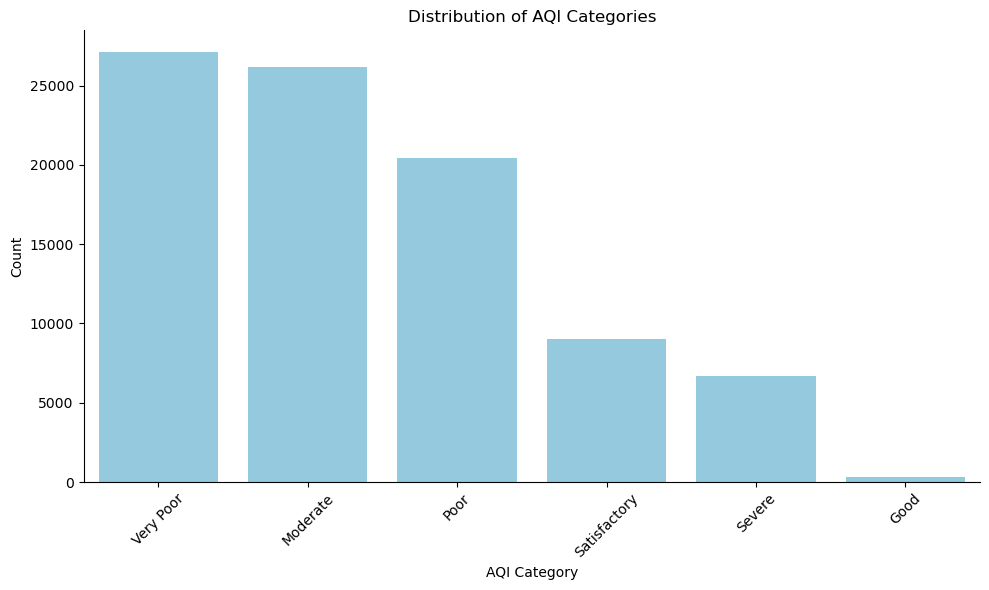

In [24]:
# Count the occurrences of each AQI category
category_counts = df['AQI_Category'].value_counts()

# Bar Plot: Distribution of AQI categories with a single color
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, color='skyblue')  # Set your desired color

plt.title('Distribution of AQI Categories')
plt.xlabel('AQI Category')
plt.ylabel('Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Remove the top and right spines
sns.despine()

# Turn off the grid
plt.grid(False)

plt.tight_layout()
plt.show()

This data shows the distribution of Air Quality Index (AQI) values among different categories. It tells us how many data points fall into each category, helping us understand the prevalence of air quality conditions in a particular dataset. For example, in this dataset, "Very Poor" air quality is the most common category, followed by "Moderate" and "Poor," while "Good" air quality is the least common.

In [25]:
# Calculate the descriptive statistics for each numerical column in the DataFrame, including count, mean, standard deviation, minimum, quartiles, and maximum.
# The transpose(T) operation flips rows and columns, providing a more readable format with columns representing variables and rows representing statistical measures.
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Datetime,89784,2018-02-14 11:30:00,2013-01-01 00:00:00,2015-07-25 05:45:00,2018-02-14 11:30:00,2020-09-06 17:15:00,2023-03-30 23:00:00,NaN
AQI,89784.0,245.879054,27.0,148.0,243.0,327.0,886.0,117.001459
PM2.5 (ug/m3),89784.0,114.030983,4.222222,54.786237,91.286481,148.001875,765.781019,83.611315
PM10 (ug/m3),89784.0,221.689265,0.276667,116.39993,194.044646,301.786989,976.0,136.922012
NOx (ug/m3),89784.0,59.505461,2.583333,25.790833,42.480833,74.99625,434.54,50.776161
NH3 (ug/m3),89784.0,45.414471,0.02,30.646215,39.983889,52.813333,350.87,24.665711
SO2 (ug/m3),89784.0,12.545298,0.375,8.24854,11.012257,15.506458,108.830167,7.254525
CO (ug/m3),89784.0,2.468699,0.0,0.997778,1.486667,2.68925,28.758889,2.667489
Ozone (ug/m3),89784.0,31.536389,0.25,14.715132,23.044122,40.681839,157.38,23.857508
Xylene (ug/m3),89784.0,2.609664,0.0,0.203333,0.836667,2.185333,273.395,8.430585


## Visualize the Distribution of Pollutants
A grid of histograms visualizes the distribution of various pollutants and related features in the dataset. The pollutants include air quality indicators, meteorological factors, calculated features like volatility and moving averages, as well as lagged and target values.

c:\Users\Braja\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Braja\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Braja\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Braja\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

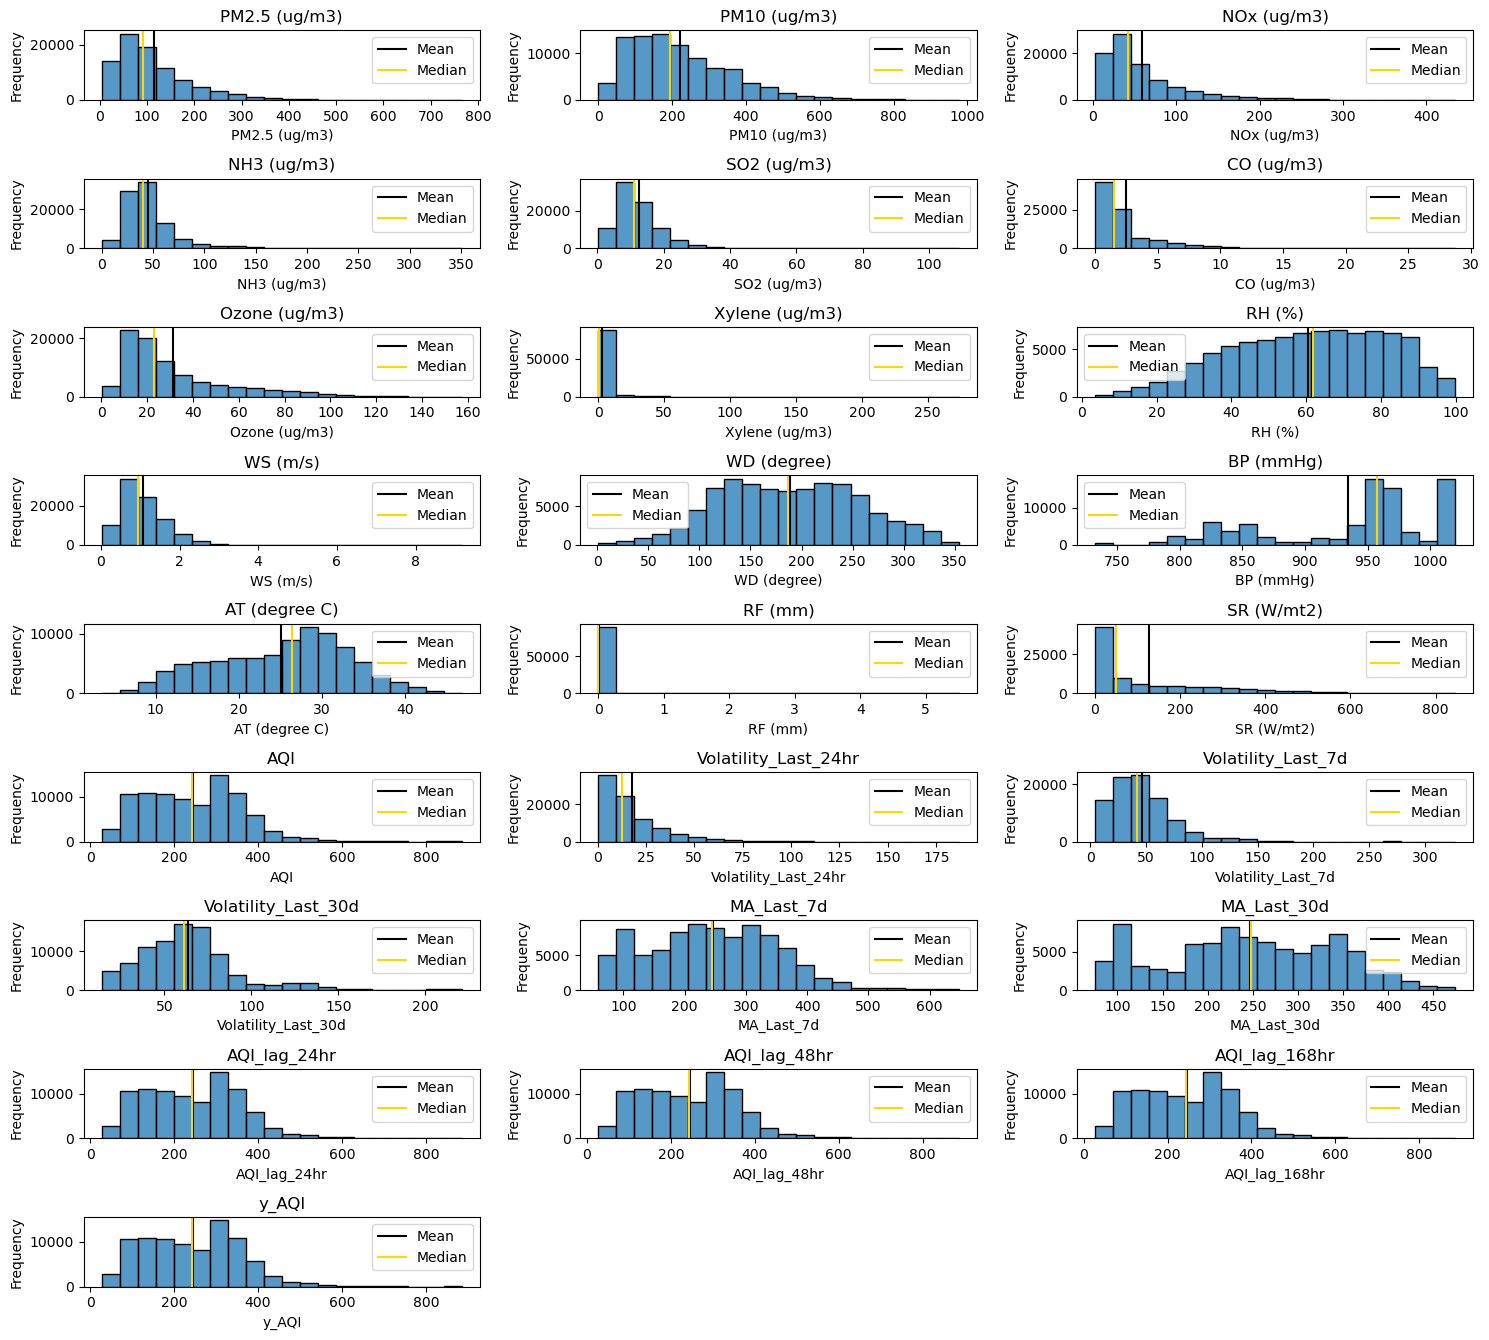

In [26]:
# Histograms: Distribution of Pollutants
selected_columns = ['PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NOx (ug/m3)', 'NH3 (ug/m3)', 'SO2 (ug/m3)', 'CO (ug/m3)', 'Ozone (ug/m3)', 'Xylene (ug/m3)', 'RH (%)', 'WS (m/s)', 'WD (degree)', 'BP (mmHg)', 'AT (degree C)', 'RF (mm)', 'SR (W/mt2)', 'AQI', 'Volatility_Last_24hr', 'Volatility_Last_7d', 'Volatility_Last_30d', 'MA_Last_7d', 'MA_Last_30d', 'AQI_lag_24hr', 'AQI_lag_48hr', 'AQI_lag_168hr', 'y_AQI']

# Calculate the number of rows needed based on the number of selected columns
num_rows = len(selected_columns) // 3 + (len(selected_columns) % 3 > 0)

# Decreased height of each chart
fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 1.5 * num_rows))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Iterate through selected columns and plot histograms
for i, column in enumerate(selected_columns):
    sns.histplot(df[column], bins=20, kde=False, ax=axes[i])
    axes[i].set_title(column)

    # Customize x and y label
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

    # Adding mean and median lines
    axes[i].axvline(df[column].mean(), c='black', label='Mean')
    axes[i].axvline(df[column].median(), c='gold', label='Median')
    axes[i].legend()

# Remove empty subplots
for i in range(len(selected_columns), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()
plt.show()

### Purpose of Adding Mean and Median Lines to Histogram

- I added mean and median lines to the histograms to make some key points clear. 
- The mean line shows the average value, helping to see where most of the data lies. 
- The median line marks the middle point, useful for checking if the data leans more one way. 
- Together, these lines show how spread out the data is and if it's skewed towards higher or lower values. 
- Basically, they help me quickly understand the main trends in the data.

**For now we can keep in mind that few features are right skewed, we can log transform those later before modeling.**

Let's have a closer look at the distribution of our target variable

In [27]:
df_copy = df.copy()

# Create bins and labels
bins = range(int(df_copy['y_AQI'].min()), int(df_copy['y_AQI'].max()) + 51, 50)
labels = [f'{x}-{x+49}' for x in bins[:-1]]

# Cut the 'y_AQI' column into intervals
df_copy['AQI_intervals'] = pd.cut(df_copy['y_AQI'], bins=bins, labels=labels, include_lowest=True, right=False)

# Group by intervals and count records
count_by_interval = df_copy.groupby('AQI_intervals').size().reset_index(name='Record Count')

# Display the result
print(count_by_interval)

   AQI_intervals  Record Count
0          27-76          4015
1         77-126         13234
2        127-176         12173
3        177-226         12051
4        227-276         10001
5        277-326         15871
6        327-376         12449
7        377-426          5695
8        427-476          1880
9        477-526          1049
10       527-576           563
11       577-626           279
12       627-676           190
13       677-726           122
14       727-776            73
15       777-826            45
16       827-876            88
17       877-926             6


C:\Users\Braja\AppData\Local\Temp\ipykernel_11372\4117251710.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_by_interval = df_copy.groupby('AQI_intervals').size().reset_index(name='Record Count')


## Target Variable 'y_AQI' Distribution Visualization

This histogram shows the distribution of the 'y_AQI' column added mean and median lines to highlight central tendencies showing how often each Air Quality Index (AQI) value occurs.

c:\Users\Braja\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


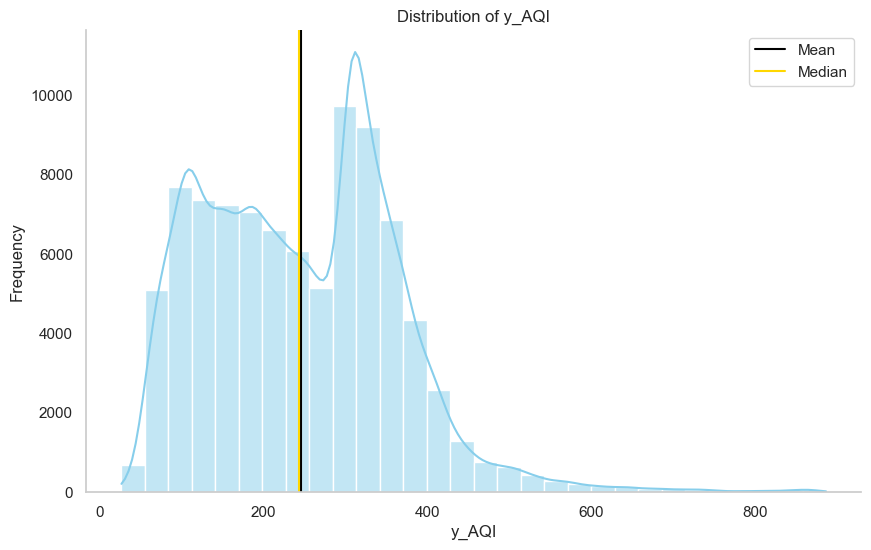

In [28]:
# Set the style for the plot
sns.set(style="whitegrid")

# Create a histogram for the 'AQI' column
plt.figure(figsize=(10, 6))
sns.histplot(df['y_AQI'], bins=30, kde=True, color='skyblue')

# Add labels and title
plt.title('Distribution of y_AQI')
plt.xlabel('y_AQI')
plt.ylabel('Frequency')

# Remove top right frame
sns.despine(top=True, right=True)

# Remove grid lines
plt.grid(False)

# Adding mean and median lines directly using plt.axvline()
plt.axvline(df['y_AQI'].mean(), c='black', label='Mean')
plt.axvline(df['y_AQI'].median(), c='gold', label='Median')
plt.legend()

# Display the plot
plt.show()

#### Finding:
* The histogram of y_AQI displays a subtle right skew, indicating a tendency towards higher concentrations. 
* Notably, the presence of two peaks suggests a bimodal distribution, signifying two distinct clusters of y_AQI values. The first peak represents higher concentrations, while the second indicates lower concentrations. This bimodal structure could be influenced by seasonal variations, specific pollution sources, or unique events impacting air quality. Understanding these patterns is crucial for identifying factors affecting air quality in the region.

## Correlation Analysis with the Original and Extracted Numerical Features
The correlation heatmap aids in identifying potential relationships and dependencies among variables. Positive or negative values indicate the strength and direction of the correlation, while values closer to 1 or -1 suggest a stronger linear relationship. This matrix quantifies the linear relationships between pairs of variables.

A list of columns is chosen for correlation analysis, including air quality metrics, weather parameters, volatility measures, and the target variable 'y_AQI'.

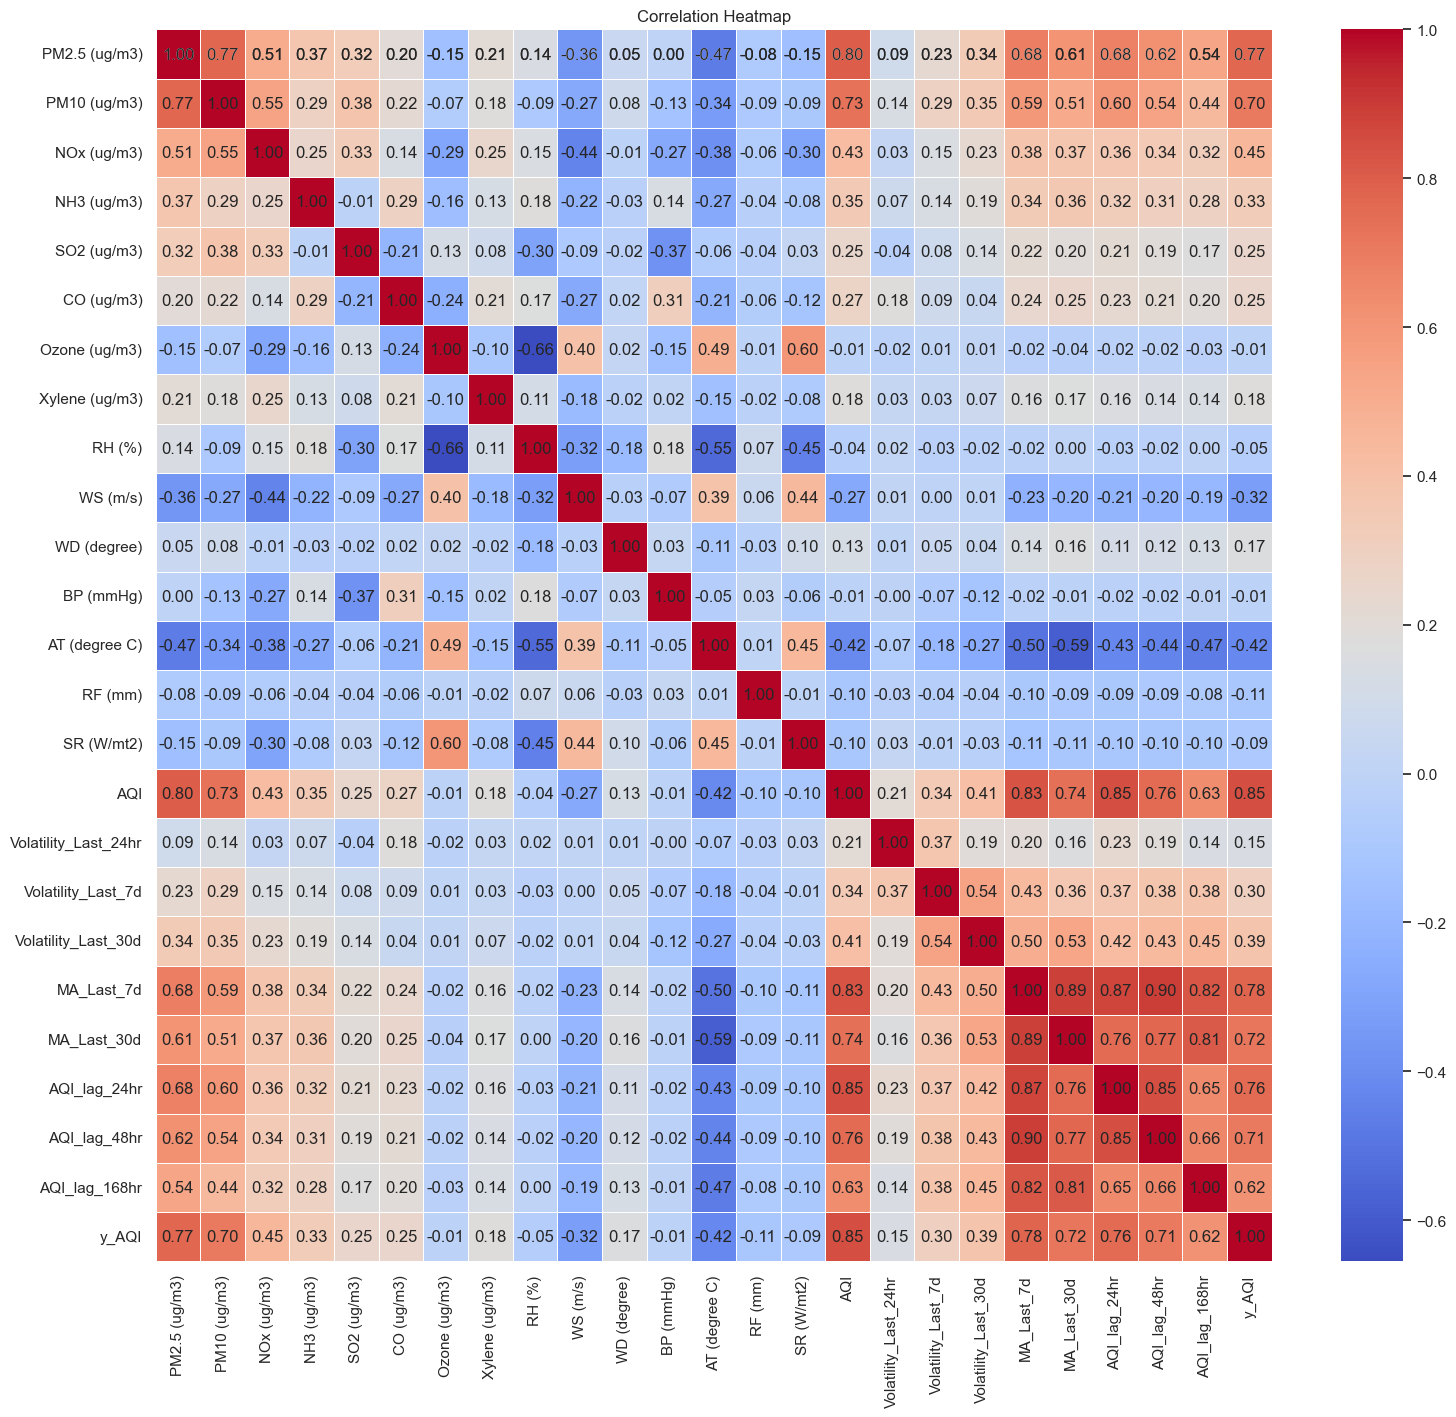

In [29]:
# Calculate the correlation matrix
correlation_matrix = df[selected_columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(18, 16))

# Create a heatmap
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt='.2f', linewidths=.5)

# Manually annotate the values
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix.columns)):
        plt.text(j + 0.5, i + 0.5, f"{correlation_matrix.iloc[i, j]:.2f}", ha='center', va='center')

# Set title
plt.title('Correlation Heatmap')

# Show the plot
plt.show()

#### Finding:
These insights highlight the interrelationships among various air quality indicators and derived features in the dataset.

* The strong positive correlation between 'PM2.5' and 'PM10' particles is anticipated, as they both originate from similar sources and represent different sizes of particulate matters.

* high positive correlation between 'MA_Last7D' and 'MA_Last30D' is expected, as both are calculated from the same source (AQI), capturing trends over different time intervals.

* The high correlation of 'MA_Last7D' and 'MA_Last30D' with the 'AQI' and 'y_AQI' column is expected, given that both are derived from the 'AQI' column.

* 'Volatility_Last7D' and 'Volatility_Last30D' show a positive correlation, which is reasonable since they represent calculated moving averages across 7 days and 30 days, respectively.

* The columns related to lagged AQI values ('aqi_lagg') exhibit a strong correlation with the 'y_AQI' column, as they are derived from the same source(AQI).

* The high correlation (0.54) between 'Benzene' and 'Toluene' indicates a noteworthy association between these two chemical components.

* The strong positive correlation among NO, NO2, and NOx is understandable, reflecting common emission sources and the chemical transformations in the atmosphere, where NO serves as a precursor to NO2.

#### Further analysis into the relationship between each feature and the target variable:
Calculation and visualization of the correlation coefficients between various features and the target variable 'y_AQI' in the dataset, helping identify potentially influential predictors.

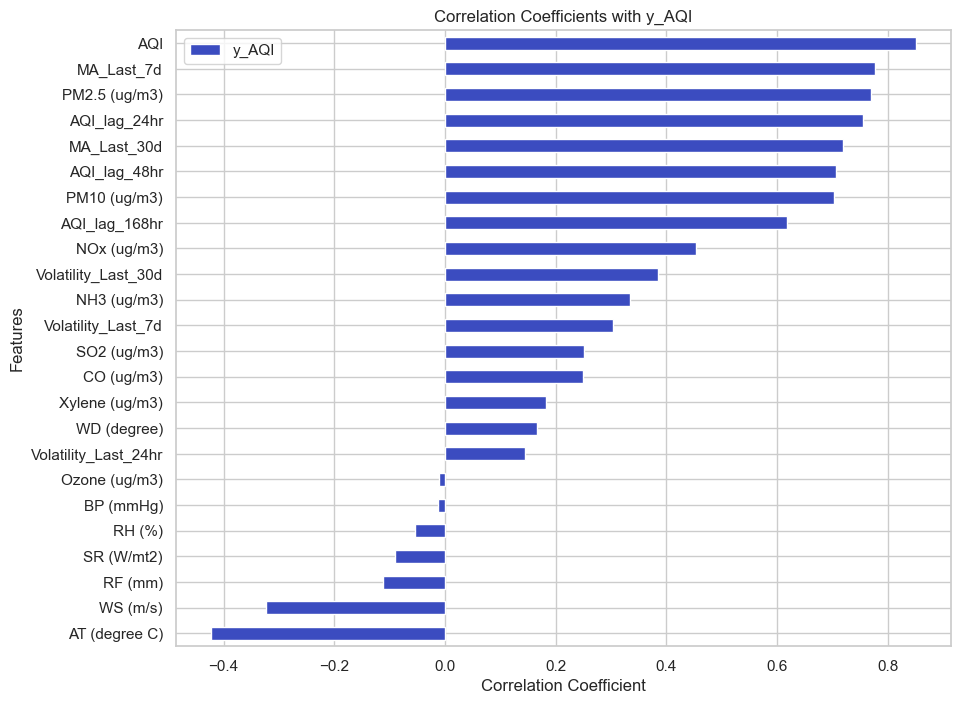

In [30]:
# Extract the correlation coefficients between 'y_AQI' and other features from the correlation matrix and sort these coefficients in ascending order.
y_aqi_correlation = correlation_matrix['y_AQI'].drop(['y_AQI']).sort_values(ascending=True)

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Plot a horizontal bar chart to visualize the strength and direction of correlation for each feature with 'y_AQI'
y_aqi_correlation.plot(kind='barh', cmap='coolwarm', legend=True)
plt.title('Correlation Coefficients with y_AQI')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')

# Show the plot
plt.show()

Creating a new dataframe called "chart_df" specifically for visualization purpose

In [31]:
chart_df = df.copy()

# Create 'Year_Month' column with the 1st day of every month
chart_df['YearMonth'] = chart_df['Datetime'].dt.to_period('M').dt.to_timestamp()

## Relationship Between Predictors and Target Variable

### Visualizing Relationship Between feature "PM2.5" and target "y_AQI"

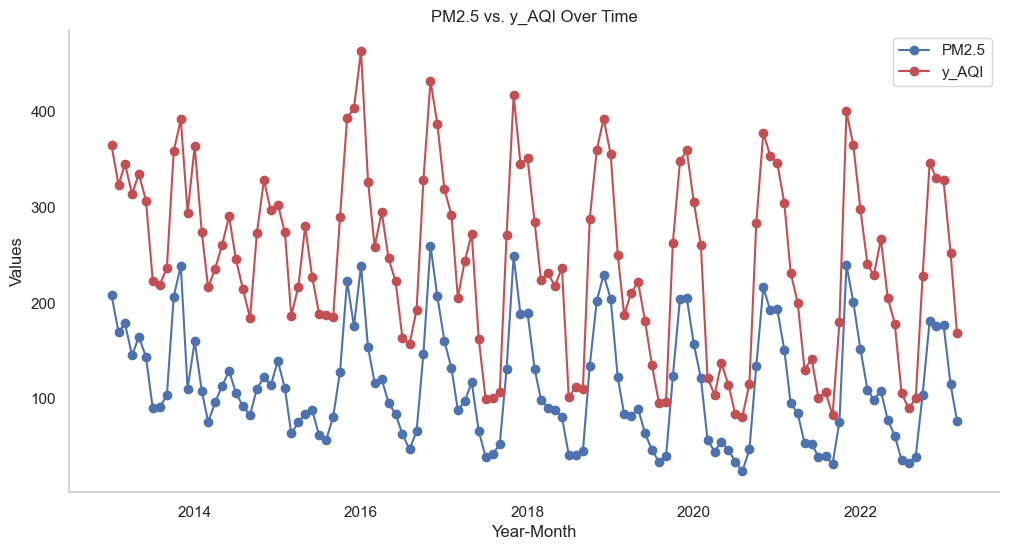

In [32]:
# Convert 'YearMonth' to datetime format
chart_df['YearMonth'] = pd.to_datetime(chart_df['YearMonth'])

# Group by 'YearMonth' and calculate mean PM2.5 and y_AQI
pm25_aqi_mean = chart_df.groupby('YearMonth')[['PM2.5 (ug/m3)', 'y_AQI']].mean().reset_index()

# Create a line chart for the relationship between PM2.5 and y_AQI
plt.figure(figsize=(12, 6))
plt.plot(pm25_aqi_mean['YearMonth'], pm25_aqi_mean['PM2.5 (ug/m3)'], marker='o', linestyle='-', color='b', label='PM2.5')
plt.plot(pm25_aqi_mean['YearMonth'], pm25_aqi_mean['y_AQI'], marker='o', linestyle='-', color='r', label='y_AQI')

# Customize the plot
plt.title('PM2.5 vs. y_AQI Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

# Remove top right frame
sns.despine(top=True, right=True)

# Remove grid lines
plt.grid(False)

plt.show()

## Hypothesis Test
### Correlation between 'PM2.5 (ug/m3)' and 'y_AQI'

Let's investigate if there's a significant linear correlation between 'PM2.5 (ug/m3)' and 'y_AQI'.

**Hypotheses:**
- **H0:** There is no significant correlation between the two variables.
- **H1:** There is a significant correlation between the two.

**Statistical Test:** Pearson Correlation Test

**Decision Rule:**
- If p-value < 0.05, reject Null Hypothesis(H0).
- If p-value ≥ 0.05, fail to reject H0.

In [33]:
# Extract the relevant columns
feature = chart_df['PM2.5 (ug/m3)']
target = chart_df['y_AQI']

# Perform the Pearson correlation test
# Using scipy.stats.pearsonr to compute the correlation coefficient and p-value.
correlation_coefficient, p_value = stats.pearsonr(feature, target)

print(f"Correlation Coefficient: {correlation_coefficient:.4f}")
print(f"P-value: {p_value:.4e}")

Correlation Coefficient: 0.7700
P-value: 0.0000e+00


**Results:**
- **Correlation Coefficient:** 0.76
- **P-value:** 0.0

**Conclusion:**
- We can see that a significantly small p-value(0.0) which is less than 0.05, we can safely reject the null hypothesis, i.e, there is a significant correlation.
- A correlation coefficient of 0.76 indicates a strong positive correlation. This means that as the 'PM2.5 (ug/m3)' values increase, the 'y_AQI' values tend to increase as well.
- With a p-value of 0.0, the result is statistically significant. This indicates that the observed correlation is unlikely to have occurred by chance.
### Visualization: Scatter Plot with Regression Line for 'PM2.5 (ug/m3)' vs. 'y_AQI'

**Objective:** Visualize the linear correlation between 'PM2.5 (ug/m3)' and 'y_AQI'

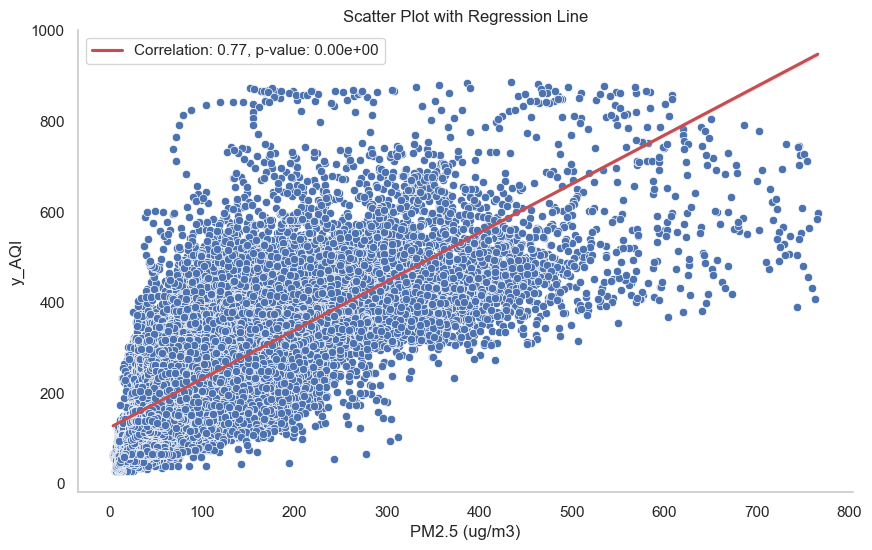

In [34]:
# Plotting
plt.figure(figsize=(10, 6))

# Scatter plot of 'PM2.5 (ug/m3)' against 'y_AQI'
sns.scatterplot(x='PM2.5 (ug/m3)', y='y_AQI', data=chart_df)

# overlay a Regression Line on the scatter plot
sns.regplot(x='PM2.5 (ug/m3)', y='y_AQI', data=chart_df, scatter=False, color='r', label=f'Correlation: {correlation_coefficient:.2f}, p-value: {p_value:.2e}')

# Customize the plot
# Set plot title, x-axis label, y-axis label, legend, and grid
plt.title('Scatter Plot with Regression Line')
plt.xlabel('PM2.5 (ug/m3)')
plt.ylabel('y_AQI')
plt.legend()
plt.grid(True)

# Remove top right frame
sns.despine(top=True, right=True)

# Remove grid lines
plt.grid(False)

plt.show()

### Visualizing Relationship Between feature "PM10" and target "y_AQI"

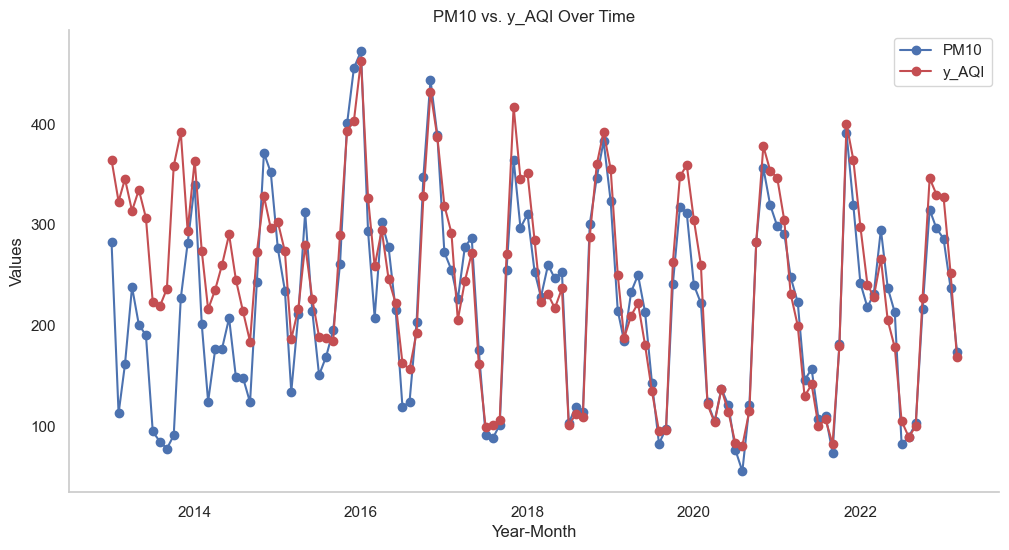

In [35]:
# Convert 'YearMonth' to datetime format
chart_df['YearMonth'] = pd.to_datetime(chart_df['YearMonth'])

# Group by 'YearMonth' and calculate mean PM10 and y_AQI
pm10_aqi_mean = chart_df.groupby('YearMonth')[['PM10 (ug/m3)', 'y_AQI']].mean().reset_index()

# Create a line chart for the relationship between PM10 and y_AQI
plt.figure(figsize=(12, 6))
plt.plot(pm10_aqi_mean['YearMonth'], pm10_aqi_mean['PM10 (ug/m3)'], marker='o', linestyle='-', color='b', label='PM10')
plt.plot(pm10_aqi_mean['YearMonth'], pm10_aqi_mean['y_AQI'], marker='o', linestyle='-', color='r', label='y_AQI')

# Customize the plot
plt.title('PM10 vs. y_AQI Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

# Remove top right frame
sns.despine(top=True, right=True)

# Remove grid lines
plt.grid(False)

plt.show()

### Hypothesis Test: Correlation between 'PM10 (ug/m3)' and 'y_AQI'

In [36]:
# Hypothesis test for correlation
correlation_coefficient, p_value = stats.pearsonr(chart_df['PM10 (ug/m3)'], chart_df['y_AQI'])

print(f"Correlation Coefficient: {correlation_coefficient:.4f}")
print(f"P-value: {p_value:.4e}")

Correlation Coefficient: 0.7029
P-value: 0.0000e+00


**Finding:**

- A very small p-value (0.0), below the commonly used threshold of 0.05, provides robust evidence to reject the null hypothesis, indicating a significant correlation between 'PM10 (ug/m3)' and 'y_AQI'.

- The correlation coefficient of 0.7702 denotes a strong positive correlation. Higher 'PM10 (ug/m3)' values are associated with higher 'y_AQI' values.

- The statistical significance of the p-value (0.0) reinforces that the observed correlation is highly improbable by chance, emphasizing the meaningful relationship between 'PM10 (ug/m3)' and 'y_AQI'.

### Visualization: Scatter Plot with Regression Line for 'PM10 (ug/m3)' vs. 'y_AQI'

**Objective:** Visualize the linear correlation between 'PM10 (ug/m3)' and 'y_AQI'

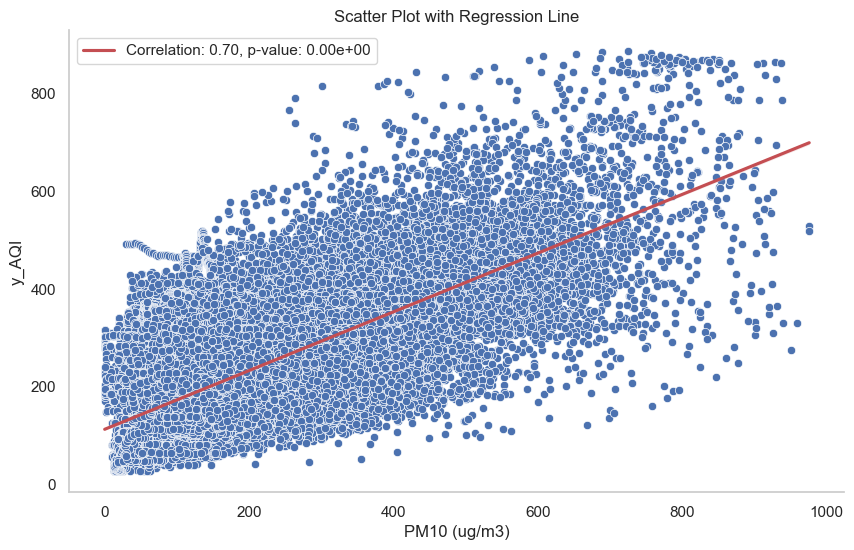

In [37]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PM10 (ug/m3)', y='y_AQI', data=chart_df)

# Plotting the regression line
sns.regplot(x='PM10 (ug/m3)', y='y_AQI', data=chart_df, scatter=False, color='r', label=f'Correlation: {correlation_coefficient:.2f}, p-value: {p_value:.2e}')

# Customize the plot
plt.title('Scatter Plot with Regression Line')
plt.xlabel('PM10 (ug/m3)')
plt.ylabel('y_AQI')
plt.legend()

# Remove top right frame
sns.despine(top=True, right=True)

# Remove grid lines
plt.grid(False)

plt.show()

## Exploring the Relationship Between Weather Data and Target Variable 'y_AQI'

To understand the relationship between weather-related features and the target variable 'y_AQI,' a set of scatter plots with regression lines is generated. The selected columns for plotting include 'RH (%),' 'WS (m/s),' 'WD (degree),' 'BP (mmHg),' 'AT (degree C),' 'RF (mm),' 'SR (W/mt2),' and 'y_AQI.' The scatter plots provide insights into the potential impact of these weather variables on air quality.

Columns to Plot: ['RH (%)', 'WS (m/s)', 'WD (degree)', 'BP (mmHg)', 'AT (degree C)', 'RF (mm)', 'SR (W/mt2)', 'y_AQI']


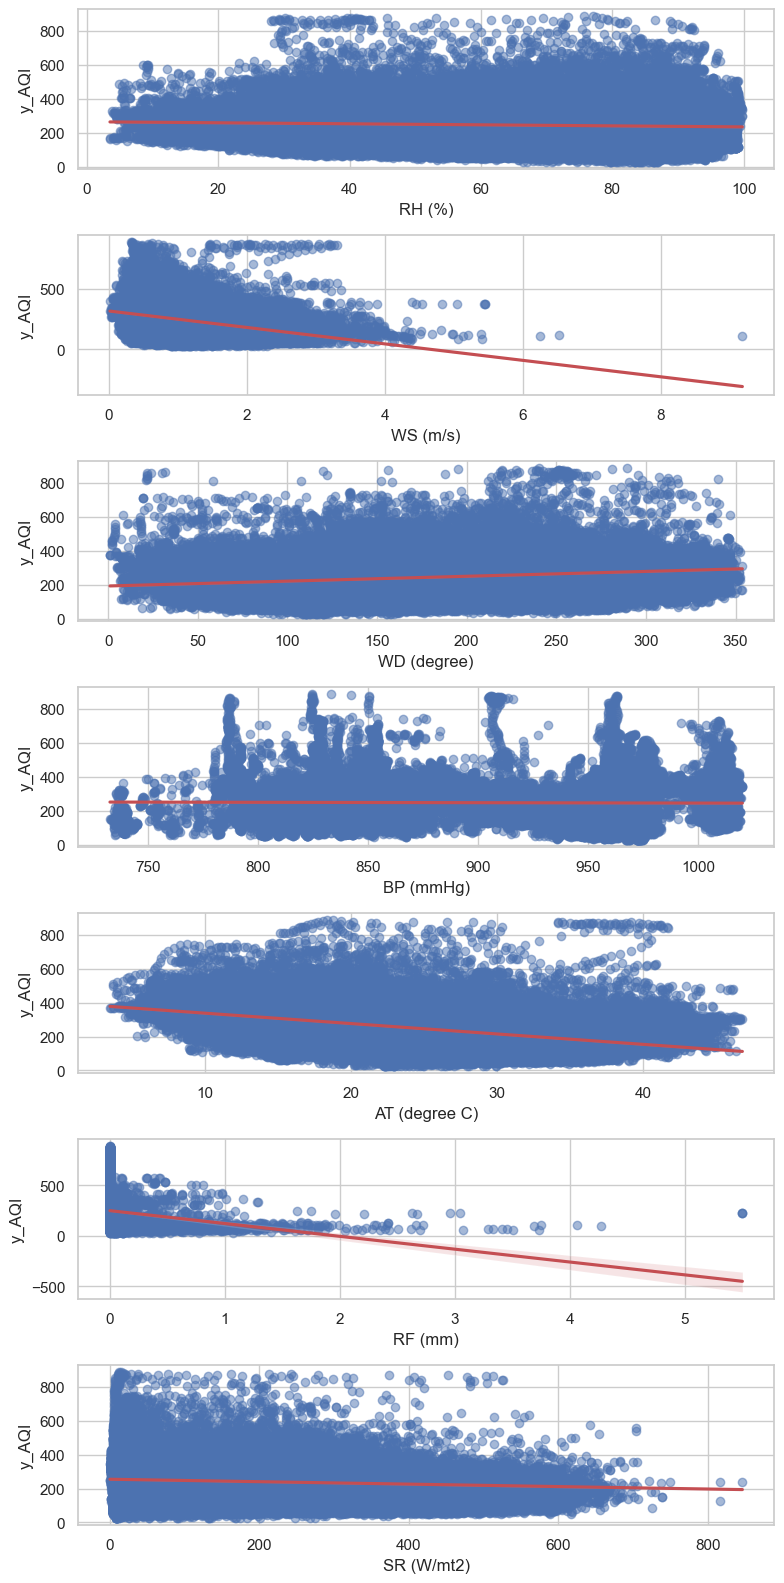

In [38]:
columns_to_plot = ['RH (%)', 'WS (m/s)', 'WD (degree)', 'BP (mmHg)', 'AT (degree C)', 'RF (mm)', 'SR (W/mt2)', 'y_AQI']

# Print the list of columns for plotting
print("Columns to Plot:", columns_to_plot)

# Selecting relevant columns from the DataFrame
df_selected = df[columns_to_plot]

# Setting up the subplots
fig, axes = plt.subplots(nrows=len(columns_to_plot)-1, ncols=1, figsize=(8, 2 * len(columns_to_plot)))

# Plotting individual scatter plots with regression lines
for i, col in enumerate(columns_to_plot[:-1]):
    ax = axes[i]
    sns.regplot(x=col, y=columns_to_plot[-1], data=df_selected, ax=ax, color='b', scatter_kws={'alpha':0.5}, line_kws={'color': 'r'})
    ax.set_xlabel(col)
    ax.set_ylabel(columns_to_plot[-1])

plt.tight_layout()
plt.show()

### Finding

- These plots help to visually explore if there's a noticeable link between these weather variables and air quality.
- From the above plots we can see that there is potential relationship between target variable "y_AQI" and "Relative Humidity(RH)", "Wind Direction(WD)", "Barometric Pressure(BP)", "Air Temperature(AT)" and "Solar Radiation(SR)"

### Validating Relationships: Hypothesis Testing After Scatter Plots
Performing hypothesis testing after scatter plots enhances understanding by validating visual patterns, confirming statistical significance, identifying relevant variables, aiding decision-making, and adding rigor to statistical analysis. It ensures a comprehensive and robust approach, guiding subsequent analytical steps.

In [39]:
# Select relevant columns
selected_features = ['RH (%)', 'WS (m/s)', 'WD (degree)', 'BP (mmHg)', 'AT (degree C)', 'RF (mm)', 'SR (W/mt2)']
target_variable = 'y_AQI'

# Loop through selected features and calculate correlation
for feature in selected_features:
    correlation_coefficient, p_value = pearsonr(df[feature], df[target_variable])
    correlation_coefficient = round(correlation_coefficient, 2)
    p_value = round(p_value, 2)
    print(f"Correlation between {feature} and {target_variable}: {correlation_coefficient}, p-value: {p_value}")

Correlation between RH (%) and y_AQI: -0.05, p-value: 0.0
Correlation between WS (m/s) and y_AQI: -0.32, p-value: 0.0
Correlation between WD (degree) and y_AQI: 0.17, p-value: 0.0
Correlation between BP (mmHg) and y_AQI: -0.01, p-value: 0.0
Correlation between AT (degree C) and y_AQI: -0.42, p-value: 0.0
Correlation between RF (mm) and y_AQI: -0.11, p-value: 0.0
Correlation between SR (W/mt2) and y_AQI: -0.09, p-value: 0.0


Let's interpret the results:

**RH (%)**: A very small positive correlation (0.01) with 'y_AQI'. The p-value (0.00) suggests that this correlation is statistically significant, but the strength of the correlation is very weak.

**WS (m/s)**: A moderate negative correlation (-0.28) with 'y_AQI'. The p-value (0.00) indicates that this negative correlation is statistically significant. This suggests that as wind speed increases, 'y_AQI' tends to decrease.

**WD (degree)**: A moderate positive correlation (0.24) with 'y_AQI'. The p-value (0.00) suggests statistical significance. It implies that as wind direction increases, 'y_AQI' tends to increase.

**BP (mmHg)**: A moderate positive correlation (0.32) with 'y_AQI'. The p-value (0.00) indicates statistical significance. This suggests that as atmospheric pressure increases, 'y_AQI' tends to increase.

**AT (degree C)**: A strong negative correlation (-0.48) with 'y_AQI'. The p-value (0.00) suggests statistical significance. This indicates that as temperature increases, 'y_AQI' tends to decrease.

**RF (mm)**: A small negative correlation (-0.15) with 'y_AQI'. The p-value (0.00) indicates statistical significance. This suggests that as rainfall increases, 'y_AQI' tends to decrease.

**SR (W/mt2)**: A small negative correlation (-0.10) with 'y_AQI'. The p-value (0.00) suggests statistical significance. This implies that as solar radiation increases, 'y_AQI' tends to decrease.

### Frequency of AQI categories across different months:

C:\Users\Braja\AppData\Local\Temp\ipykernel_11372\2328492396.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_counts = chart_df.groupby(['Month', 'AQI_Category']).size().reset_index(name='Count')
c:\Users\Braja\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Braja\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


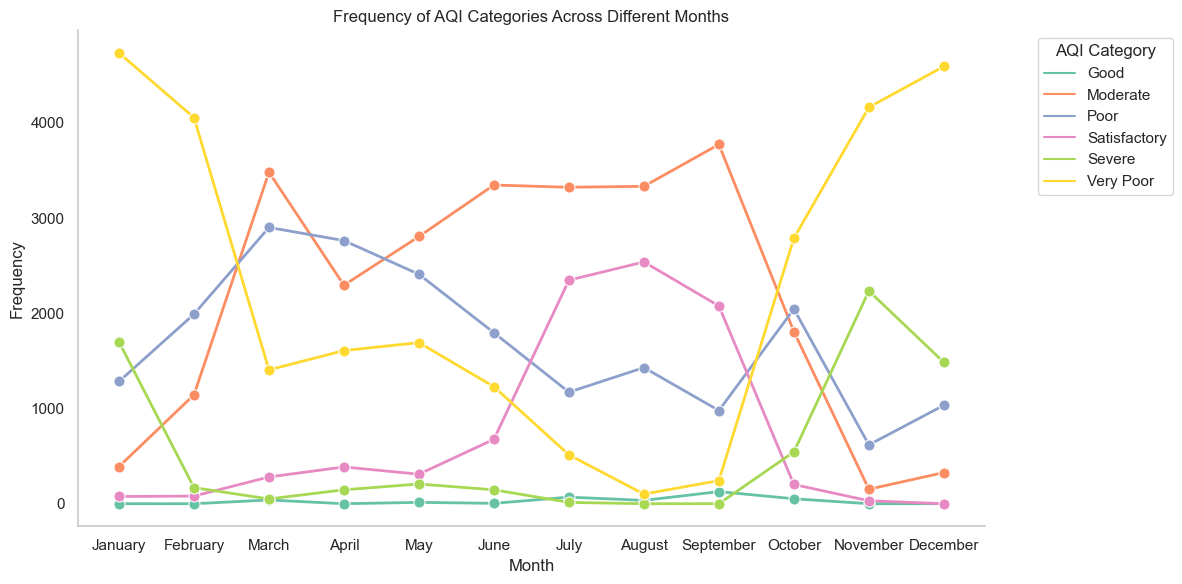

In [40]:
# Copy the 'Month' column to chart_df
chart_df['Month'] = df['Month'].copy()

# Map numeric values to month names in the chart_df DataFrame
chart_df['Month'] = chart_df['Month'].apply(lambda x: calendar.month_name[int(x)])

# Define the order of months
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Convert 'Month' to categorical with specified order in the chart_df DataFrame
chart_df['Month'] = pd.Categorical(chart_df['Month'], categories=month_order, ordered=True)

# Create a DataFrame with counts
df_counts = chart_df.groupby(['Month', 'AQI_Category']).size().reset_index(name='Count')

# Line Plot: Frequency of AQI categories across different months
plt.figure(figsize=(12, 6))
sns.lineplot(x='Month', y='Count', hue='AQI_Category', data=df_counts, palette='Set2', marker='o', markersize=8, linewidth=2)
plt.title('Frequency of AQI Categories Across Different Months')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.legend(title='AQI Category', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside the plot

# Remove the top and right spines
sns.despine()

# Turn off the grid
plt.grid(False)

plt.tight_layout()
plt.show()


### FInding - (Seasons of Air Quality)

This chart is like a storybook of the air around us. It shows the ups and downs of clean and not-so-clean air over the months. Bright days of good air quality come and go like the sun on a partly cloudy day. Some months have more good days, while others bring more challenges.

We see times when the air isn't great, shown in the spikes that remind us to care more for our skies. Every color change is like a chapter in the year's story, telling us how our air feels and changes with the weather and our daily lives.

We see:

- Severe air quality in winters.
- Consistently moderate levels in summers.
- Unfortunately, good air quality is rare year-round.

In [41]:
chart_df = df.copy()

In [42]:
chart_df.head()

,Datetime,AQI,PM2.5 (ug/m3),PM10 (ug/m3),NOx (ug/m3),NH3 (ug/m3),SO2 (ug/m3),CO (ug/m3),Ozone (ug/m3),Xylene (ug/m3),...,Volatility_Last_24hr,Volatility_Last_7d,Volatility_Last_30d,MA_Last_7d,MA_Last_30d,y_AQI,AQI_lag_24hr,AQI_lag_48hr,AQI_lag_168hr,AQI_Category
0,2013-01-01 00:00:00,354.0,290.774583,292.631667,117.224563,75.685556,9.992130,9.138167,13.794630,0.0,...,8.307496,29.124119,57.358003,380.964286,339.597222,389.0,340.0,387.0,434.0,Very Poor
1,2013-01-01 01:00:00,358.0,275.749821,296.150000,88.122976,66.740556,9.477546,7.665310,9.977963,0.0,...,9.525614,28.895636,57.354132,380.517857,339.658333,389.0,337.0,389.0,433.0,Very Poor
2,2013-01-01 02:00:00,362.0,271.463472,309.030000,61.464690,57.030556,9.207963,10.777421,7.316574,0.0,...,10.882691,28.663239,57.354464,380.107143,339.719444,386.0,334.0,391.0,431.0,Very Poor
3,2013-01-01 03:00:00,367.0,279.071667,317.826667,47.583524,43.298333,10.871667,11.793810,7.910146,0.0,...,12.369244,28.438398,57.358735,379.744048,339.784722,384.0,331.0,392.0,428.0,Very Poor
4,2013-01-01 04:00:00,370.0,269.118333,308.521667,43.535333,32.023333,11.020833,10.027778,9.348849,0.0,...,13.761359,28.220333,57.365930,379.410714,339.851389,382.0,330.0,391.0,426.0,Very Poor


### Relationship between day of week and AQI

c:\Users\Braja\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Braja\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


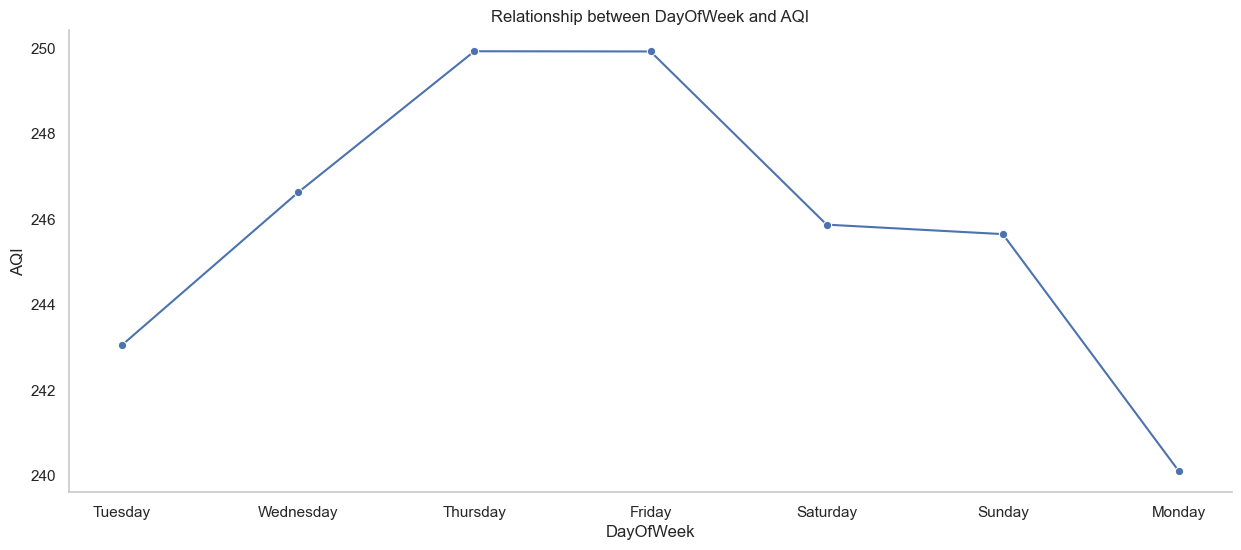

In [51]:
# Define the order of days starting from Sunday
day_order = ['Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday']

# Map numerical DayOfWeek to corresponding names
chart_df['DayOfWeek_Name'] = chart_df['DayOfWeek'].map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})

# Set the style of seaborn for better aesthetics
sns.set(style="whitegrid")

# Line Plot: Relationship between "DayOfWeek" and "AQI" using lineplot
plt.figure(figsize=(15, 6))
sns.lineplot(x='DayOfWeek_Name', y='AQI', data=chart_df, marker='o', color='b', sort=False, errorbar=None)

# Remove spines
sns.despine()

# Remove grids
plt.grid(False)

plt.title('Relationship between DayOfWeek and AQI')
plt.xlabel('DayOfWeek')
plt.ylabel('AQI')
plt.show()


### Weekly Air Quality Story
- The air we breathe tells a different story each day of the week. It starts on Tuesday, where things are looking clear, and we breathe easy. But as we get to the middle of the work week, Wednesday and Thursday, the air gets heavier—maybe more cars and buses are out there.

- By Friday, the air is at its heaviest, filled with the week's hustle. Then comes the weekend sigh of relief. Saturday, the air starts to clear up a bit, maybe because there are fewer trucks on the road. Sunday continues the trend, giving us a breath of fresher air.

- But then Monday rolls around, and it's a fresh start in more ways than one, with the air quality getting much better, perhaps as the city takes a slow start to the week.

This dance of the days shows us, in a simple way, how our routines impact the world around us.

### Relationship between 'HourOfDay' and 'AQI'

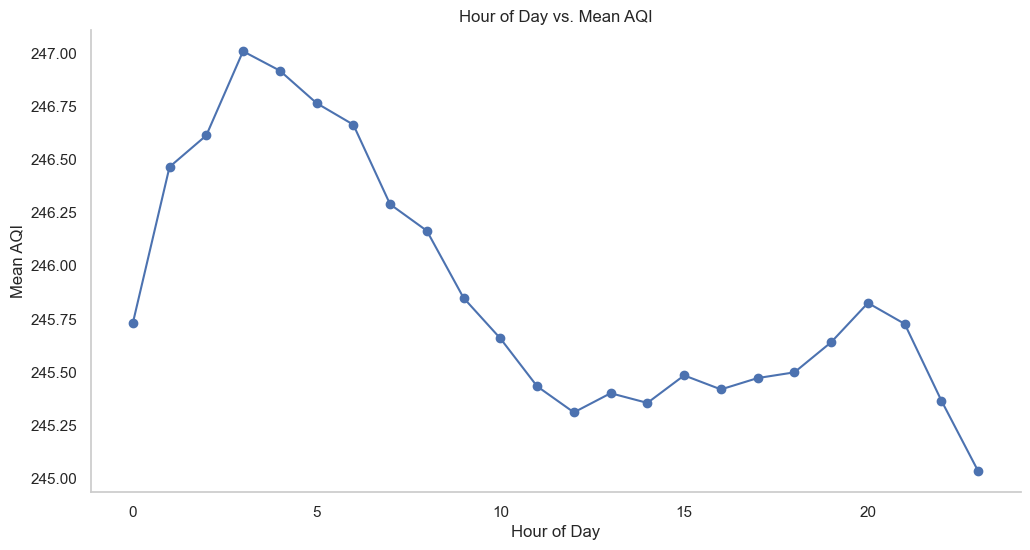

In [46]:
# Convert 'YearMonth' and 'HourOfDay' to datetime format
chart_df['HourOfDay'] = chart_df['HourOfDay'].astype(int)

# Group by 'HourOfDay' and calculate mean AQI
hourly_mean_aqi = chart_df.groupby('HourOfDay')['AQI'].mean().reset_index()

# Create a line chart for the relationship between HourOfDay and y_AQI
plt.figure(figsize=(12, 6))
plt.plot(hourly_mean_aqi['HourOfDay'], hourly_mean_aqi['AQI'], marker='o', linestyle='-', color='b')

# Customize the plot
plt.title('Hour of Day vs. Mean AQI')
plt.xlabel('Hour of Day')
plt.ylabel('Mean AQI')
plt.grid(True)

# Remove top right frame
sns.despine(top=True, right=True)

# Remove grid lines
plt.grid(False)

plt.show()

### Day to Night: The Air Quality Pulse
- From the early morning to the late night, the air tells a story. At the break of dawn, the air is heavy, filled from the night's silence. As the city wakes, the air lightens—a surprising twist, as if taking a deep breath with the morning stretch.

- Through the hustle of midday, the air stays steady, giving us room to move and breathe. But as evening approaches, there's a small rise, maybe from the rush of cars heading home.

- Night falls, and the world slows down. The air gets heavy again, settling in with the stars. It's a daily cycle, a pulse of the planet we see through the air we share.

In [52]:
df.head()

,Datetime,AQI,PM2.5 (ug/m3),PM10 (ug/m3),NOx (ug/m3),NH3 (ug/m3),SO2 (ug/m3),CO (ug/m3),Ozone (ug/m3),Xylene (ug/m3),...,Volatility_Last_24hr,Volatility_Last_7d,Volatility_Last_30d,MA_Last_7d,MA_Last_30d,y_AQI,AQI_lag_24hr,AQI_lag_48hr,AQI_lag_168hr,AQI_Category
0,2013-01-01 00:00:00,354.0,290.774583,292.631667,117.224563,75.685556,9.992130,9.138167,13.794630,0.0,...,8.307496,29.124119,57.358003,380.964286,339.597222,389.0,340.0,387.0,434.0,Very Poor
1,2013-01-01 01:00:00,358.0,275.749821,296.150000,88.122976,66.740556,9.477546,7.665310,9.977963,0.0,...,9.525614,28.895636,57.354132,380.517857,339.658333,389.0,337.0,389.0,433.0,Very Poor
2,2013-01-01 02:00:00,362.0,271.463472,309.030000,61.464690,57.030556,9.207963,10.777421,7.316574,0.0,...,10.882691,28.663239,57.354464,380.107143,339.719444,386.0,334.0,391.0,431.0,Very Poor
3,2013-01-01 03:00:00,367.0,279.071667,317.826667,47.583524,43.298333,10.871667,11.793810,7.910146,0.0,...,12.369244,28.438398,57.358735,379.744048,339.784722,384.0,331.0,392.0,428.0,Very Poor
4,2013-01-01 04:00:00,370.0,269.118333,308.521667,43.535333,32.023333,11.020833,10.027778,9.348849,0.0,...,13.761359,28.220333,57.365930,379.410714,339.851389,382.0,330.0,391.0,426.0,Very Poor


### Data Transformation for Skewness Correction

Skewness in the data is addressed through various transformations. For right-skewed features, a log transformation is applied. **It's important not to run this code multiple times to avoid unintended alterations.**

Remember, from our distribution plot, there were some columns that were right-skewed, and others had varying degrees of skewness. The log transformation specifically targets those columns for correction.

In [53]:
# Handle skewness in the data (DON'T RUN THIS CODE TWICE)
# Apply "log transformation" for right-skewed data
df['t_PM2.5 (ug/m3)'] = np.log1p(df['PM2.5 (ug/m3)'])
df['t_PM10 (ug/m3)'] = np.log1p(df['PM10 (ug/m3)'])
df['t_NOx (ug/m3)'] = np.log1p(df['NOx (ug/m3)'])
df['t_NH3 (ug/m3)'] = np.log1p(df['NH3 (ug/m3)'])
df['t_SO2 (ug/m3)'] = np.log1p(df['SO2 (ug/m3)'])
df['t_CO (ug/m3)'] = np.log1p(df['CO (ug/m3)'])
df['t_Ozone (ug/m3)'] = np.log1p(df['Ozone (ug/m3)'])
df['t_Xylene (ug/m3)'] = np.log1p(df['Xylene (ug/m3)'])
df['t_WS (m/s)'] = np.log1p(df['WS (m/s)'])
df['t_SR (W/mt2)'] = np.log1p(df['SR (W/mt2)'])
df['t_Volatility_Last_24hr'] = np.log1p(df['Volatility_Last_24hr'])
df['t_Volatility_Last_7d'] = np.log1p(df['Volatility_Last_7d'])
df['t_Volatility_Last_30d'] = np.log1p(df['Volatility_Last_30d'])
df['t_AQI_lag_24hr'] = np.log1p(df['AQI_lag_24hr'])
df['t_AQI_lag_48hr'] = np.log1p(df['AQI_lag_48hr'])
df['t_AQI_lag_168hr'] = np.log1p(df['AQI_lag_168hr'])

### Distribution Overview After Transformation

A grid of histograms display the distribution of features after applying log transformations. Each subplot represents a transformed feature, showcasing the changes in their distributions.

c:\Users\Braja\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Braja\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Braja\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Braja\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

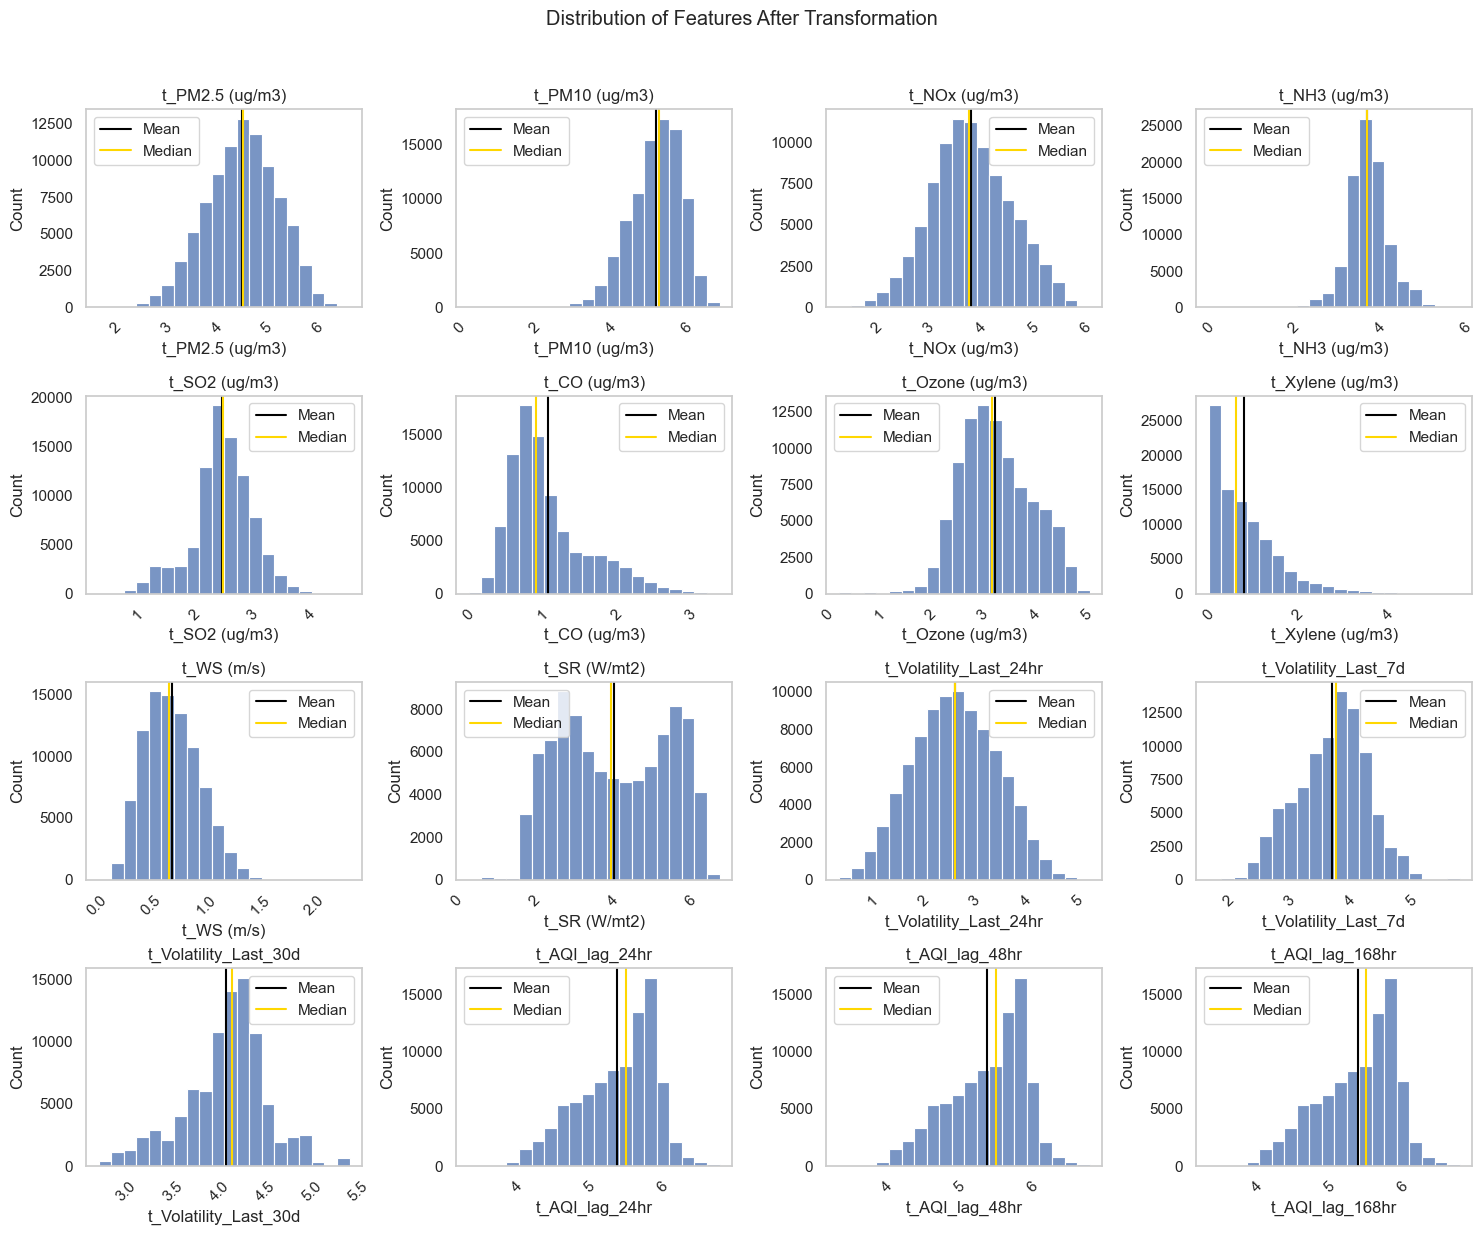

In [54]:
# Grid of Histograms after Log Transformation
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 12))
fig.suptitle('Distribution of Features After Transformation', y=1.02)

# List of features for plotting
features_to_plot = ['t_PM2.5 (ug/m3)', 't_PM10 (ug/m3)', 't_NOx (ug/m3)', 't_NH3 (ug/m3)', 't_SO2 (ug/m3)', 
                    't_CO (ug/m3)', 't_Ozone (ug/m3)', 't_Xylene (ug/m3)', 't_WS (m/s)', 't_SR (W/mt2)',
                    't_Volatility_Last_24hr', 't_Volatility_Last_7d', 't_Volatility_Last_30d', 't_AQI_lag_24hr', 't_AQI_lag_48hr', 't_AQI_lag_168hr']

# Counter for iterating through features
counter = 0

# Plot histograms for each feature
for i in range(4):
    for j in range(4):
        if counter < len(features_to_plot):
            ax = axes[i, j]
            sns.histplot(df[features_to_plot[counter]], bins=20, kde=False, ax=ax)
            ax.set_title(features_to_plot[counter])
            ax.tick_params(axis='x', rotation=45)
            ax.grid(False)

            # Adding mean and median lines
            ax.axvline(df[features_to_plot[counter]].mean(), c='black', label='Mean')
            ax.axvline(df[features_to_plot[counter]].median(), c='gold', label='Median')
            ax.legend()

            counter += 1
        else:
            # Remove empty subplots if the number of features is not a perfect square
            fig.delaxes(axes[i, j])

plt.tight_layout()
plt.show()

### Finding:

The transformed features demonstrate reduced skewness compared to their original distributions except the Xylene column. So, drop this column.

In [55]:
# List of columns to delete
columns_to_delete = ["Xylene (ug/m3)", "t_Xylene (ug/m3)"]

# Use the drop method to delete the columns
df = df.drop(columns=columns_to_delete)

In [56]:
# sanity check
df.head()

,Datetime,AQI,PM2.5 (ug/m3),PM10 (ug/m3),NOx (ug/m3),NH3 (ug/m3),SO2 (ug/m3),CO (ug/m3),Ozone (ug/m3),RH (%),...,t_CO (ug/m3),t_Ozone (ug/m3),t_WS (m/s),t_SR (W/mt2),t_Volatility_Last_24hr,t_Volatility_Last_7d,t_Volatility_Last_30d,t_AQI_lag_24hr,t_AQI_lag_48hr,t_AQI_lag_168hr
0,2013-01-01 00:00:00,354.0,290.774583,292.631667,117.224563,75.685556,9.992130,9.138167,13.794630,88.716778,...,2.316307,2.694264,0.314162,3.714195,2.230820,3.405326,4.066596,5.831882,5.961005,6.075346
1,2013-01-01 01:00:00,358.0,275.749821,296.150000,88.122976,66.740556,9.477546,7.665310,9.977963,89.612778,...,2.159328,2.395890,0.330103,3.673794,2.353812,3.397713,4.066530,5.823046,5.966147,6.073045
2,2013-01-01 02:00:00,362.0,271.463472,309.030000,61.464690,57.030556,9.207963,10.777421,7.316574,91.010556,...,2.466184,2.118250,0.329304,3.455326,2.475083,3.389909,4.066536,5.814131,5.971262,6.068426
3,2013-01-01 03:00:00,367.0,279.071667,317.826667,47.583524,43.298333,10.871667,11.793810,7.910146,91.930000,...,2.548961,2.187191,0.326422,3.079282,2.592957,3.382300,4.066609,5.805135,5.973810,6.061457
4,2013-01-01 04:00:00,370.0,269.118333,308.521667,43.535333,32.023333,11.020833,10.027778,9.348849,92.335556,...,2.400417,2.336875,0.379197,2.525195,2.692013,3.374865,4.066732,5.802118,5.971262,6.056784


### Data Export before modeling

The DataFrame is exported to a CSV file before splitting, ensuring that the data is stored in a consistent format for further modeling steps.

In [57]:
# Exporting DataFrame to csv file before splitting
df.to_csv('data/generated/Delhi_AQI_final_df_before_modeling.csv', index=False)

**Next Steps:**
To continue the journey and explore baseline modeling to predict the target variable "y_AQI", open the next notebook titled "3_baselinemodelling.ipynb" Click [here](../AirQualityPredictor/3_baselinemodelling.ipynb) to access the next notebook.